In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1, anchor = "4_3")
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2, anchor = "4_3")

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 7, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_r1b2_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 7, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)


In [3]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

disc = ae.discriminator(hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [4]:
pre_train_ae(model = ae1, data_loader = train_r1b1_loader, diff_sim = Diff1, optimizer = optimizer_rna, P = U_t1, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.45958, recon loss: 0.00000, dist loss: 0.45958
epoch:  10 Total loss: 0.16767, recon loss: 0.00000, dist loss: 0.16767
epoch:  20 Total loss: 0.09978, recon loss: 0.00000, dist loss: 0.09978
epoch:  30 Total loss: 0.07996, recon loss: 0.00000, dist loss: 0.07996
epoch:  40 Total loss: 0.08108, recon loss: 0.00000, dist loss: 0.08108
epoch:  50 Total loss: 0.07890, recon loss: 0.00000, dist loss: 0.07890
epoch:  60 Total loss: 0.08091, recon loss: 0.00000, dist loss: 0.08091
epoch:  70 Total loss: 0.07852, recon loss: 0.00000, dist loss: 0.07852
epoch:  80 Total loss: 0.08285, recon loss: 0.00000, dist loss: 0.08285
epoch:  90 Total loss: 0.07828, recon loss: 0.00000, dist loss: 0.07828
epoch:  100 Total loss: 0.07729, recon loss: 0.00000, dist loss: 0.07729


In [5]:
pre_train_ae(model = ae2, data_loader = train_r1b2_loader, diff_sim = Diff2, optimizer = optimizer_atac, P = U_t2, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.40504, recon loss: 0.00000, dist loss: 0.40504
epoch:  10 Total loss: 0.12618, recon loss: 0.00000, dist loss: 0.12618
epoch:  20 Total loss: 0.09627, recon loss: 0.00000, dist loss: 0.09627
epoch:  30 Total loss: 0.08836, recon loss: 0.00000, dist loss: 0.08836
epoch:  40 Total loss: 0.09540, recon loss: 0.00000, dist loss: 0.09540
epoch:  50 Total loss: 0.09023, recon loss: 0.00000, dist loss: 0.09023
epoch:  60 Total loss: 0.08233, recon loss: 0.00000, dist loss: 0.08233
epoch:  70 Total loss: 0.07675, recon loss: 0.00000, dist loss: 0.07675
epoch:  80 Total loss: 0.07535, recon loss: 0.00000, dist loss: 0.07535
epoch:  90 Total loss: 0.07177, recon loss: 0.00000, dist loss: 0.07177
epoch:  100 Total loss: 0.08365, recon loss: 0.00000, dist loss: 0.08365


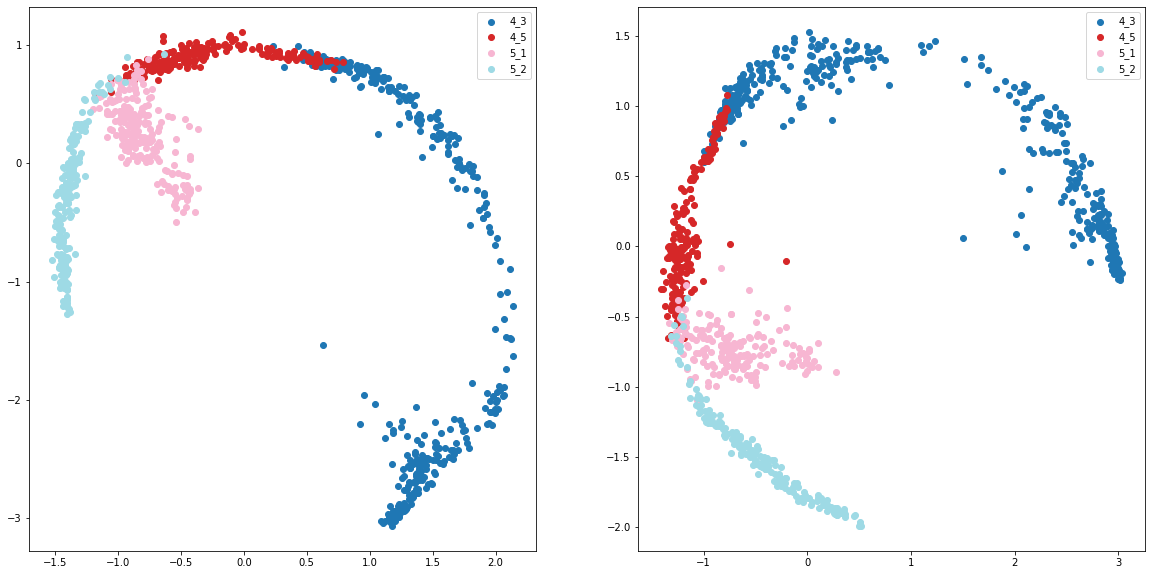

In [6]:
with torch.no_grad():
    for data in test_r1b1_loader:
        ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

    for data in test_r1b2_loader:
        ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "separate",save = None)

In [7]:
pre_train_disc(model_rna = ae1, model_atac = ae2, disc = disc, data_loader_rna = train_r1b1_loader, data_loader_atac = train_r1b2_loader, optimizer_D = optimizer_D, n_epochs = 101, use_anchor = True)

epoch:  0 Discriminator loss: 0.72577
epoch:  10 Discriminator loss: 0.57411
epoch:  20 Discriminator loss: 0.48506
epoch:  30 Discriminator loss: 0.33775
epoch:  40 Discriminator loss: 0.23976
epoch:  50 Discriminator loss: 0.17880
epoch:  60 Discriminator loss: 0.16788
epoch:  70 Discriminator loss: 0.16650
epoch:  80 Discriminator loss: 0.12694
epoch:  90 Discriminator loss: 0.10941
epoch:  100 Discriminator loss: 0.08927


In [8]:
# n_iter = 200 merge too good
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=201, n_iter=100, n_iter2 = 1, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "mse", use_anchor = True)

epoch:  0 RNA loss: 0.22960, RNA recon loss: 0.00000, RNA dist loss: 0.22960 ATAC loss: 0.17836, ATAC recon loss: 0.00000, ATAC dist loss: 0.17836 Discriminator loss: 0.30436
epoch:  10 RNA loss: 0.14350, RNA recon loss: 0.00000, RNA dist loss: 0.14350 ATAC loss: 0.14549, ATAC recon loss: 0.00000, ATAC dist loss: 0.14549 Discriminator loss: 0.63781
epoch:  20 RNA loss: 0.13258, RNA recon loss: 0.00000, RNA dist loss: 0.13258 ATAC loss: 0.14890, ATAC recon loss: 0.00000, ATAC dist loss: 0.14890 Discriminator loss: 0.57686
epoch:  30 RNA loss: 0.11950, RNA recon loss: 0.00000, RNA dist loss: 0.11950 ATAC loss: 0.11354, ATAC recon loss: 0.00000, ATAC dist loss: 0.11354 Discriminator loss: 0.65998
epoch:  40 RNA loss: 0.10348, RNA recon loss: 0.00000, RNA dist loss: 0.10348 ATAC loss: 0.10444, ATAC recon loss: 0.00000, ATAC dist loss: 0.10444 Discriminator loss: 0.67484
epoch:  50 RNA loss: 0.09389, RNA recon loss: 0.00000, RNA dist loss: 0.09389 ATAC loss: 0.09129, ATAC recon loss: 0.0000

In [15]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config': symsim_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/symsim_phate_pretrain.pt')

In [9]:
# state = torch.load('./saved_model/symsim_phate.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

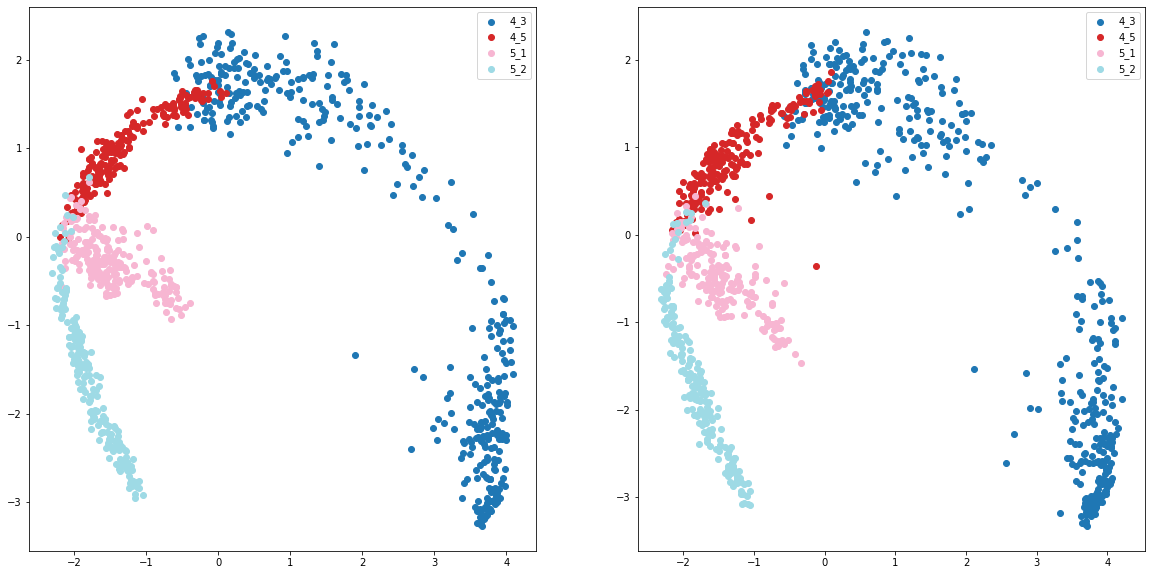

In [9]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "separate",save = None)

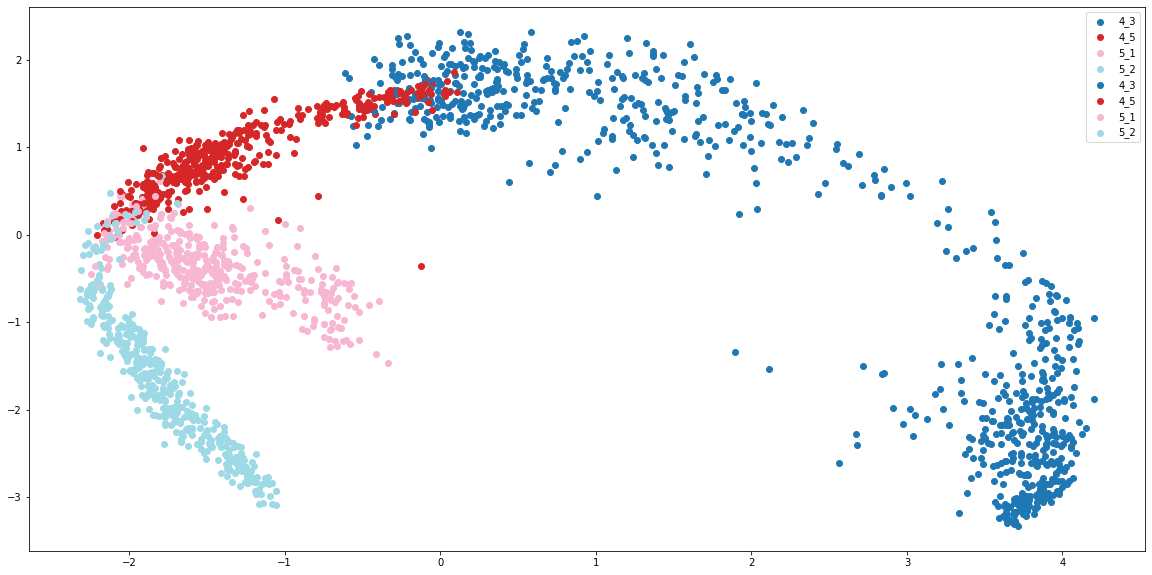

In [10]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "joint",save = None)